C:\Users\kauan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\kauan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


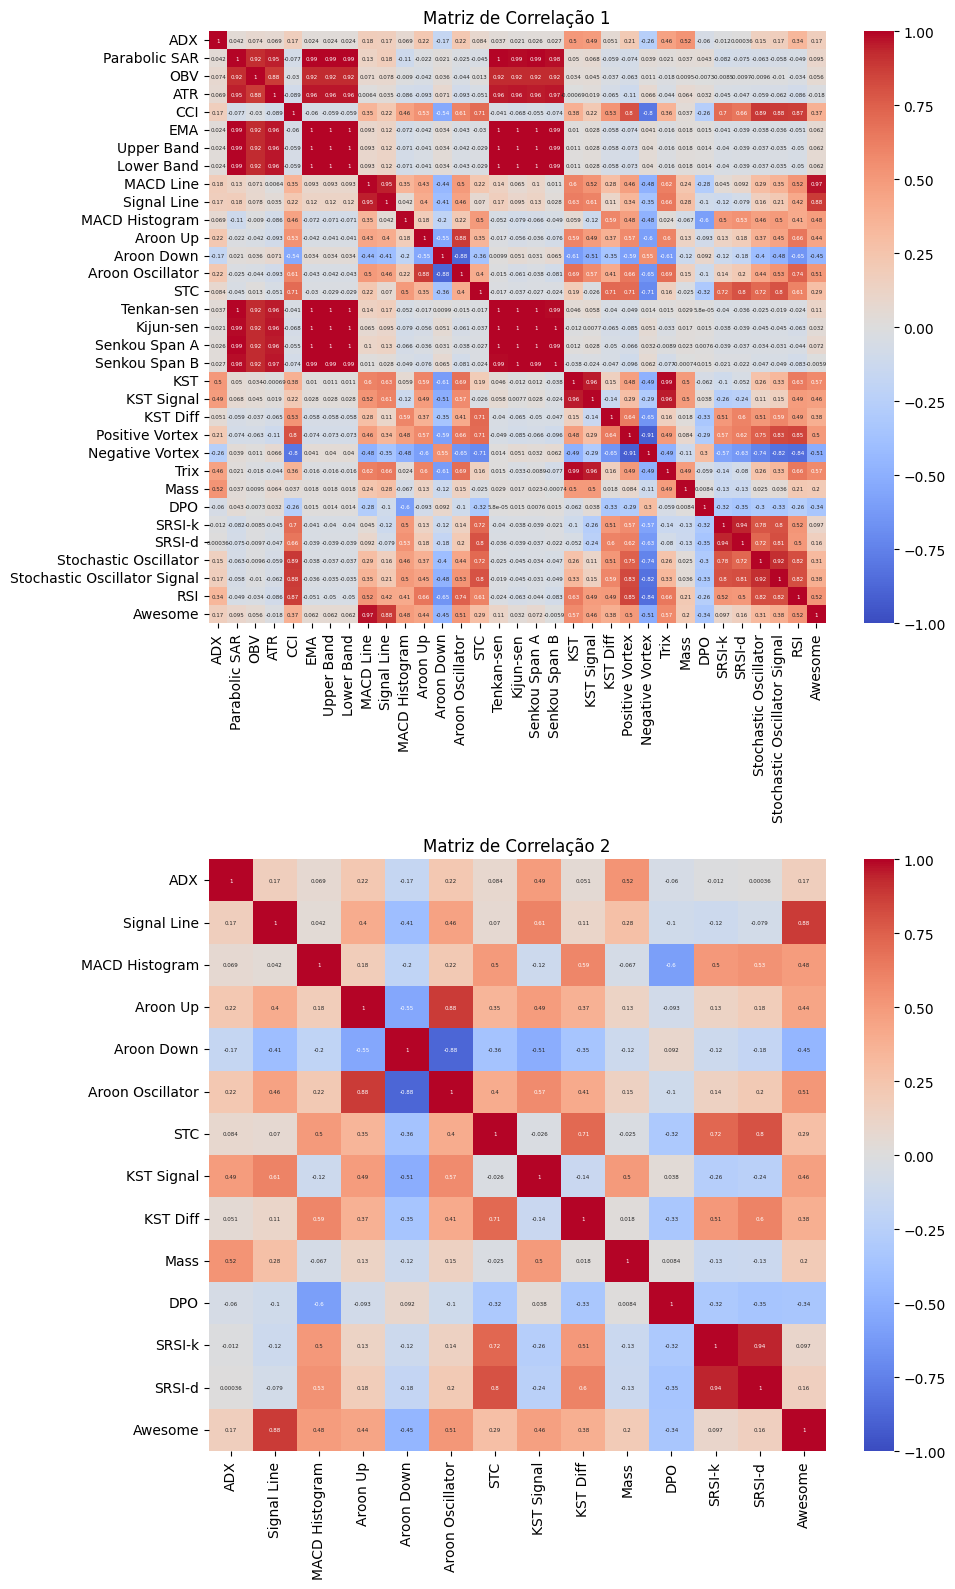

Loading BokehJS ...

In [1]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import tradingUtils
from tradingUtils import *
from indicadores import *
import labeling as lb
import backtesting
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from bokeh.io import output_notebook
output_notebook()
backtesting.set_bokeh_output(notebook=True)

In [ ]:
DATA = prio_data
YEAR = None

In [ ]:
# Função a ser executada: faz o backtesting para um dado modelo e ano
# Se "year" for passado, ele faz o backtest nesse ano
# Se não, ele faz nos últimos 365 dias de dado
def backtesting_model(ohlc, model, year = None, **kwargs):
    # Calculando os indicadores
    indicators = agg_indicators(ohlc)
    indicators = normalize_indicators(indicators)
    # Calculando o rótulo
    y = np.array(lb.labelData(ohlc, 0.1)).ravel()
    # Eliminando as linhas com NaN
    indicators["y"] = y
    indicators = indicators.dropna()
    # Separando os dados de treino e backtest com base no ano selecionado
    # Se tiver um ano específico, separa ele para backtest
    if year:
        indicators_train = indicators[indicators.index.year != year]
        indicators_backtest = indicators[indicators.index.year == year]
    # Se não, pega os últimos 365 dias
    else:
        last_day = indicators.index[-1]
        indicators_train = indicators[indicators.index <= last_day - pd.DateOffset(years = 1)]
        indicators_backtest = indicators[indicators.index > last_day - pd.DateOffset(years = 1)]
    # Convertendo para numpy arrays, caso ainda não estejam
    X = np.array(indicators_train)[:, :-1]
    y = np.array(indicators_train)[:, -1]
    # Treinando o modelo
    model = model(X, y, **kwargs)
    # Predizendo a política para aquele ano
    pred = model.predict(np.array(indicators_backtest)[:, :-1])
    # Salvando a predição em um dataframe adequado (próximas 4 linhas)
    # Pegando os dados originais do período de backtest
    if year:
        ohlc_backtest = ohlc[ohlc.index.year != year]
    else:
        last_day = ohlc.index[-1]
        ohlc_backtest = ohlc[ohlc.index > last_day - pd.DateOffset(years = 1)]
    # Criando uma série com a predição e o index do ano
    policy = pd.Series(pred, index = ohlc_backtest.index)
    # Colocando a predição nesse dataframe
    ohlc_backtest["Signal"] = 0
    ohlc_backtest.loc[policy.index, "Signal"] = policy

    return ohlc_backtest

## Fazendo a Rede Neural

In [4]:
def mlp(data, y, hidden_layers=(100, 100, 100), activation='logistic', 
        solver='adam', max_iter=500, random_state=42):
    """
    Treina um modelo de rede neural MLP e retorna as previsões e o relatório de classificação.

    Parâmetros:
    - data: DataFrame contendo os dados de entrada.
    - hidden_layers: Tupla com o tamanho das camadas ocultas.
    - activation: Função de ativação a ser usada.
    - solver: Algoritmo de otimização a ser usado.
    - max_iter: Número máximo de iterações.
    - random_state: Semente para a geração de números aleatórios.

    Retorna:
    - y_pred_mlp: Previsões das classes no conjunto de teste.
    - report: Relatório de classificação.
    """
    # Divide os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

    # Definindo a rede neural com múltiplas camadas
    mlp = MLPClassifier(hidden_layer_sizes = hidden_layers,
                        activation = activation,
                        solver = solver,
                        max_iter = max_iter,
                        random_state = random_state)

    # Treina a rede neural
    mlp.fit(X_train, y_train)

    # Faz previsões de classe
    y_pred_mlp = mlp.predict(X_test)

    # Exibe o relatório de classificação para o MLP
    report = classification_report(y_test, y_pred_mlp)
    print(report)

    return mlp

In [5]:
# Testando o modelo
dados_mlp = backtesting_model(DATA, mlp, year = YEAR)

C:\Users\kauan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


              precision    recall  f1-score   support

        -1.0       0.49      0.60      0.54       299
         0.0       0.00      0.00      0.00        34
         1.0       0.50      0.44      0.47       290

    accuracy                           0.49       623
   macro avg       0.33      0.35      0.34       623
weighted avg       0.47      0.49      0.48       623



C:\Users\kauan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\kauan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kauan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

In [6]:
bt = Backtest(dados_mlp, OurStrategy, cash=10000)
stats = bt.run()

# Exibindo o resultado
bt.plot()
print(stats)

C:\Users\kauan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\backtesting\_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')


Start                     2023-08-22 00:00:00
End                       2024-08-21 00:00:00
Duration                    365 days 00:00:00
Exposure Time [%]                        90.8
Equity Final [$]                  8594.379403
Equity Peak [$]                  10466.520211
Return [%]                         -14.056206
Buy & Hold Return [%]                3.880266
Return (Ann.) [%]                  -14.160291
Volatility (Ann.) [%]               24.311824
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -29.636121
Avg. Drawdown [%]                   -10.58009
Max. Drawdown Duration      341 days 00:00:00
Avg. Drawdown Duration      116 days 00:00:00
# Trades                                    7
Win Rate [%]                        28.571429
Best Trade [%]                      16.492086
Worst Trade [%]                     -7.857916
Avg. Trade [%]                    

## Fazendo o modelo de Random Forest

In [7]:
def random_forest(data, y, n_estimators=100, max_depth=None, random_state=42):
    """
    Treina um modelo de Random Forest e retorna as previsões e o relatório de classificação.

    Parâmetros:
    - data: DataFrame com as features e a variável alvo.
    - target_column: Nome da coluna alvo no DataFrame.
    - n_estimators: Número de árvores na floresta.
    - max_depth: Profundidade máxima das árvores (None para ilimitado).
    - random_state: Semente para a geração de números aleatórios.

    Retorna:
    - y_pred_rf: Previsões das classes no conjunto de teste.
    - report: Relatório de classificação.
    """
    # Divide os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

    # Definindo o modelo Random Forest
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                 random_state=random_state)

    # Treina o modelo Random Forest
    rf.fit(X_train, y_train)

    # Faz previsões de classe
    y_pred_rf = rf.predict(X_test)

    # Exibe o relatório de classificação para o Random Forest
    report = classification_report(y_test, y_pred_rf)
    print(report)

    return rf

In [8]:
# Testando o modelo
dados_rf = backtesting_model(DATA, random_forest, year = YEAR)

C:\Users\kauan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


              precision    recall  f1-score   support

        -1.0       0.50      0.56      0.53       299
         0.0       0.10      0.03      0.05        34
         1.0       0.49      0.47      0.48       290

    accuracy                           0.49       623
   macro avg       0.36      0.35      0.35       623
weighted avg       0.47      0.49      0.48       623



C:\Users\kauan\AppData\Local\Temp\ipykernel_7556\330422410.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  olhc_backtest["Signal"] = 0


In [10]:
bt = Backtest(dados_rf, OurStrategy, cash=10000)
stats = bt.run()
print(stats)

# Exibindo o resultado
bt.plot()
print(stats)

Start                     2023-08-22 00:00:00
End                       2024-08-21 00:00:00
Duration                    365 days 00:00:00
Exposure Time [%]                        26.8
Equity Final [$]                  7944.699572
Equity Peak [$]                  10054.449622
Return [%]                         -20.553004
Buy & Hold Return [%]                3.880266
Return (Ann.) [%]                  -20.699103
Volatility (Ann.) [%]                9.407561
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -21.383568
Avg. Drawdown [%]                  -13.578384
Max. Drawdown Duration      231 days 00:00:00
Avg. Drawdown Duration      171 days 00:00:00
# Trades                                   20
Win Rate [%]                             35.0
Best Trade [%]                       1.896782
Worst Trade [%]                     -6.341875
Avg. Trade [%]                    

C:\Users\kauan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\backtesting\_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')


Start                     2023-08-22 00:00:00
End                       2024-08-21 00:00:00
Duration                    365 days 00:00:00
Exposure Time [%]                        26.8
Equity Final [$]                  7944.699572
Equity Peak [$]                  10054.449622
Return [%]                         -20.553004
Buy & Hold Return [%]                3.880266
Return (Ann.) [%]                  -20.699103
Volatility (Ann.) [%]                9.407561
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -21.383568
Avg. Drawdown [%]                  -13.578384
Max. Drawdown Duration      231 days 00:00:00
Avg. Drawdown Duration      171 days 00:00:00
# Trades                                   20
Win Rate [%]                             35.0
Best Trade [%]                       1.896782
Worst Trade [%]                     -6.341875
Avg. Trade [%]                    

## Fazendo o Modelo Gradient Boosting

In [ ]:
def gradient_boosting(data, y, random_state=42):
    """
    Treina um modelo de Gradient Boosting e retorna as previsões e o relatório de classificação.

    Parâmetros:
    - data: DataFrame com as features e a variável alvo.
    - target_column: Nome da coluna alvo no DataFrame.
    - random_state: Semente para a geração de números aleatórios.

    Retorna:
    - y_pred_gb: Previsões das classes no conjunto de teste.
    - report: Relatório de classificação.
    """
    # Divide os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

    # Definindo o modelo Gradient Boosting
    gb_model = GradientBoostingClassifier(random_state=random_state)

    # Treina o modelo Gradient Boosting
    gb_model.fit(X_train, y_train)

    # Faz previsões de classe
    y_pred_gb = gb_model.predict(X_test)

    # Exibe o relatório de classificação para o Gradient Boosting
    report = classification_report(y_test, y_pred_gb)
    print(report)

    return gb_model

In [ ]:
dados_gb = backtesting_model(DATA, gradient_boosting, year = YEAR)

C:\Users\kauan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


              precision    recall  f1-score   support

        -1.0       0.51      0.57      0.54       299
         0.0       0.25      0.09      0.13        34
         1.0       0.49      0.47      0.48       290

    accuracy                           0.50       623
   macro avg       0.42      0.38      0.38       623
weighted avg       0.49      0.50      0.49       623



C:\Users\kauan\AppData\Local\Temp\ipykernel_20724\330422410.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  olhc_backtest["Signal"] = 0


In [ ]:
bt = Backtest(dados_gb, OurStrategy, cash=10000)
stats = bt.run()

# Exibindo o resultado
bt.plot()
print(stats)

Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal length
Error in strategy: cannot add indices of unequal

C:\Users\kauan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\backtesting\_plotting.py:455: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample_rule, label='left')


Start                     2023-08-22 00:00:00
End                       2024-08-21 00:00:00
Duration                    365 days 00:00:00
Exposure Time [%]                        99.2
Equity Final [$]                  9826.399132
Equity Peak [$]                  11540.699566
Return [%]                          -1.736009
Buy & Hold Return [%]                3.880266
Return (Ann.) [%]                   -1.749775
Volatility (Ann.) [%]                30.46801
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -18.233575
Avg. Drawdown [%]                   -9.644046
Max. Drawdown Duration      180 days 00:00:00
Avg. Drawdown Duration       60 days 00:00:00
# Trades                                    2
Win Rate [%]                             50.0
Best Trade [%]                       1.220037
Worst Trade [%]                     -2.927251
Avg. Trade [%]                    